## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Transform the Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## Load the Data

In [4]:
# Load CIFAR 10 dataset with training and testing Components
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize a few images

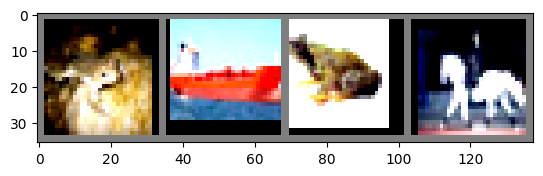

In [5]:
import matplotlib.pyplot as plt
import numpy as np


batch_size = 4

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

## Define ResNet Architecture

We have modified the architecture to reduce blocks in layers. The following modifications were made to ResNet 18 architecture found at https://github.com/kuangliu/pytorch-cifar. 

- Reducing blocks from 2 to 1 in layer 2,3,4 
- Dropout of 0.2 added 
- SGD Optimizer 

In [6]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,1,1,1])

In [7]:
net = ResNet18()

In [8]:
## Move model to CUDA
net = net.to(device)

## Model Summary and Parameters
eters
We are checking total number of trainable params and visualizing the model summary

In [9]:
summary(net, input_size = (3,32,32), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [10]:
total_trainable_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [11]:
print("Total Trainable Parameters: %d"%total_trainable_parameters)

Total Trainable Parameters: 4977226


Which is under 5 million :)

## Define Train and Test functions 

In [12]:
# Training
def train(epoch):
    
    ## Setting the model in training mode
    net.train()
    
    ## Initialize Epoch loss and accuracy 
    train_loss = 0
    train_acc = 0 
    
    ## Number of correct examples
    correct = 0
    total = 0


    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ## Movie inputs and targets to cuda
        inputs, targets = inputs.to(device), targets.to(device)

        ## Set gradients to zero after every batch
        optimizer.zero_grad()

        ## Get predictions
        outputs = net(inputs)

        ## Compute Loss
        loss = criterion(outputs, targets)

        ## Do backprop
        loss.backward()

        ## Update weights 
        optimizer.step()

        ## Add loss
        train_loss += loss.item()
        
        ## Computer Number of correct examples
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    
    
    
    train_acc += 100.*correct/total


   
    
    return train_loss / len(trainloader) , train_acc

In [13]:
def test(epoch):
    ## Setting models to evaluation mode
    net.eval()
    
    ## Initialize epoch loss and accuracy
    test_loss = 0
    test_acc = 0 

    ## Number of correct examples
    correct = 0
    total = 0


    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            ## Move inputs and targets to cuda

            inputs, targets = inputs.to(device), targets.to(device)

            ## Get predictions

            outputs = net(inputs)

            ## Compute Loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            ## Computer Accuracy 
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    test_acc = 100.*correct/total
    
    return test_loss / len(testloader) , test_acc

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Defining Loss function, optimizer and LR Scheduler

In [15]:
LEARNING_RATE = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE,
                       weight_decay=5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = criterion.to(device)

## Train the model


In [16]:
EPOCHS = 150
best_testing_accuracy = 0 

## Define model history to store accuracy and losses

history = {}
history["accuracy"] = []
history["test_accuracy"] = []
history["loss"] = []
history["test_loss"] = []

In [17]:
## First train for 150 

for epoch in tqdm(range(EPOCHS)):
  
  start_time = time.time()

  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)

  scheduler.step()

  history["accuracy"].append(train_acc)
  history["test_accuracy"].append(test_acc)
  history["loss"].append(train_loss)
  history["test_loss"].append(test_loss)


  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if test_acc > best_testing_accuracy:
    best_testing_accuracy = test_acc
    torch.save(net.state_dict(), 'model.pt')

  
  print('Training Loss: %.3f | Training Acc: %.3f%% | Testing Loss: %.3f | Testing Acc:%.3f%%'
                  % (train_loss, train_acc, test_loss, test_acc))

  1%|          | 1/150 [00:40<1:41:29, 40.87s/it]

Training Loss: 1.436 | Training Acc: 47.304% | Testing Loss: 1.178 | Testing Acc:59.160%


  1%|▏         | 2/150 [01:19<1:37:21, 39.47s/it]

Training Loss: 0.988 | Training Acc: 64.674% | Testing Loss: 1.015 | Testing Acc:66.580%


  2%|▏         | 3/150 [01:57<1:35:10, 38.85s/it]

Training Loss: 0.792 | Training Acc: 72.176% | Testing Loss: 0.934 | Testing Acc:69.170%


  3%|▎         | 4/150 [02:35<1:33:47, 38.54s/it]

Training Loss: 0.681 | Training Acc: 76.212% | Testing Loss: 0.691 | Testing Acc:76.300%


  3%|▎         | 5/150 [03:14<1:33:25, 38.66s/it]

Training Loss: 0.602 | Training Acc: 79.068% | Testing Loss: 0.684 | Testing Acc:77.450%


  4%|▍         | 6/150 [03:51<1:31:48, 38.25s/it]

Training Loss: 0.543 | Training Acc: 81.210% | Testing Loss: 0.686 | Testing Acc:77.570%


  5%|▍         | 7/150 [04:33<1:33:51, 39.38s/it]

Training Loss: 0.500 | Training Acc: 82.818% | Testing Loss: 0.555 | Testing Acc:81.680%


  5%|▌         | 8/150 [05:11<1:32:09, 38.94s/it]

Training Loss: 0.460 | Training Acc: 84.106% | Testing Loss: 0.560 | Testing Acc:82.070%


  6%|▌         | 9/150 [05:49<1:30:33, 38.54s/it]

Training Loss: 0.431 | Training Acc: 85.122% | Testing Loss: 0.546 | Testing Acc:81.630%


  7%|▋         | 10/150 [06:28<1:30:10, 38.65s/it]

Training Loss: 0.403 | Training Acc: 86.160% | Testing Loss: 0.550 | Testing Acc:82.410%


  7%|▋         | 11/150 [07:06<1:29:15, 38.53s/it]

Training Loss: 0.383 | Training Acc: 86.818% | Testing Loss: 0.537 | Testing Acc:83.170%


  8%|▊         | 12/150 [07:44<1:28:22, 38.42s/it]

Training Loss: 0.357 | Training Acc: 87.636% | Testing Loss: 0.529 | Testing Acc:83.650%


  9%|▊         | 13/150 [08:23<1:27:57, 38.52s/it]

Training Loss: 0.337 | Training Acc: 88.330% | Testing Loss: 0.548 | Testing Acc:83.140%


  9%|▉         | 14/150 [09:01<1:27:15, 38.50s/it]

Training Loss: 0.321 | Training Acc: 88.996% | Testing Loss: 0.475 | Testing Acc:84.790%


 10%|█         | 15/150 [09:39<1:26:13, 38.32s/it]

Training Loss: 0.305 | Training Acc: 89.470% | Testing Loss: 0.516 | Testing Acc:83.830%


 11%|█         | 16/150 [10:17<1:25:22, 38.23s/it]

Training Loss: 0.287 | Training Acc: 90.148% | Testing Loss: 0.458 | Testing Acc:84.650%


 11%|█▏        | 17/150 [10:55<1:24:16, 38.02s/it]

Training Loss: 0.275 | Training Acc: 90.440% | Testing Loss: 0.509 | Testing Acc:84.470%


 12%|█▏        | 18/150 [11:32<1:23:17, 37.86s/it]

Training Loss: 0.266 | Training Acc: 90.726% | Testing Loss: 0.401 | Testing Acc:87.060%


 13%|█▎        | 19/150 [12:10<1:22:33, 37.81s/it]

Training Loss: 0.251 | Training Acc: 91.382% | Testing Loss: 0.490 | Testing Acc:85.100%


 13%|█▎        | 20/150 [12:48<1:21:53, 37.79s/it]

Training Loss: 0.241 | Training Acc: 91.606% | Testing Loss: 0.453 | Testing Acc:86.160%


 14%|█▍        | 21/150 [13:25<1:21:02, 37.69s/it]

Training Loss: 0.229 | Training Acc: 92.026% | Testing Loss: 0.392 | Testing Acc:88.020%


 15%|█▍        | 22/150 [14:03<1:20:38, 37.80s/it]

Training Loss: 0.226 | Training Acc: 92.306% | Testing Loss: 0.377 | Testing Acc:88.110%


 15%|█▌        | 23/150 [14:41<1:20:12, 37.89s/it]

Training Loss: 0.218 | Training Acc: 92.332% | Testing Loss: 0.465 | Testing Acc:85.960%


 16%|█▌        | 24/150 [15:19<1:19:34, 37.89s/it]

Training Loss: 0.202 | Training Acc: 92.958% | Testing Loss: 0.392 | Testing Acc:87.710%


 17%|█▋        | 25/150 [15:58<1:19:24, 38.12s/it]

Training Loss: 0.198 | Training Acc: 93.160% | Testing Loss: 0.364 | Testing Acc:88.690%


 17%|█▋        | 26/150 [16:36<1:19:05, 38.27s/it]

Training Loss: 0.187 | Training Acc: 93.564% | Testing Loss: 0.363 | Testing Acc:88.700%


 18%|█▊        | 27/150 [17:15<1:18:26, 38.26s/it]

Training Loss: 0.177 | Training Acc: 93.878% | Testing Loss: 0.358 | Testing Acc:89.360%


 19%|█▊        | 28/150 [17:53<1:17:57, 38.34s/it]

Training Loss: 0.176 | Training Acc: 93.892% | Testing Loss: 0.483 | Testing Acc:86.050%


 19%|█▉        | 29/150 [18:31<1:17:07, 38.25s/it]

Training Loss: 0.167 | Training Acc: 94.280% | Testing Loss: 0.423 | Testing Acc:87.690%


 20%|██        | 30/150 [19:08<1:15:50, 37.92s/it]

Training Loss: 0.167 | Training Acc: 94.136% | Testing Loss: 0.368 | Testing Acc:88.830%


 21%|██        | 31/150 [19:46<1:15:17, 37.96s/it]

Training Loss: 0.155 | Training Acc: 94.598% | Testing Loss: 0.456 | Testing Acc:86.820%


 21%|██▏       | 32/150 [20:24<1:14:40, 37.97s/it]

Training Loss: 0.154 | Training Acc: 94.580% | Testing Loss: 0.404 | Testing Acc:88.330%


 22%|██▏       | 33/150 [21:02<1:13:43, 37.81s/it]

Training Loss: 0.145 | Training Acc: 95.024% | Testing Loss: 0.339 | Testing Acc:89.510%


 23%|██▎       | 34/150 [21:39<1:12:59, 37.76s/it]

Training Loss: 0.139 | Training Acc: 95.130% | Testing Loss: 0.481 | Testing Acc:86.260%


 23%|██▎       | 35/150 [22:17<1:12:27, 37.80s/it]

Training Loss: 0.136 | Training Acc: 95.202% | Testing Loss: 0.357 | Testing Acc:89.370%


 24%|██▍       | 36/150 [22:55<1:11:50, 37.82s/it]

Training Loss: 0.130 | Training Acc: 95.500% | Testing Loss: 0.368 | Testing Acc:89.380%


 25%|██▍       | 37/150 [23:33<1:11:21, 37.89s/it]

Training Loss: 0.123 | Training Acc: 95.740% | Testing Loss: 0.361 | Testing Acc:89.640%


 25%|██▌       | 38/150 [24:12<1:11:06, 38.10s/it]

Training Loss: 0.116 | Training Acc: 96.082% | Testing Loss: 0.344 | Testing Acc:90.120%


 26%|██▌       | 39/150 [24:50<1:10:27, 38.09s/it]

Training Loss: 0.117 | Training Acc: 95.924% | Testing Loss: 0.349 | Testing Acc:89.940%


 27%|██▋       | 40/150 [25:28<1:10:04, 38.22s/it]

Training Loss: 0.109 | Training Acc: 96.242% | Testing Loss: 0.361 | Testing Acc:89.630%


 27%|██▋       | 41/150 [26:07<1:09:48, 38.42s/it]

Training Loss: 0.111 | Training Acc: 96.186% | Testing Loss: 0.356 | Testing Acc:89.920%


 28%|██▊       | 42/150 [26:45<1:08:43, 38.18s/it]

Training Loss: 0.105 | Training Acc: 96.410% | Testing Loss: 0.344 | Testing Acc:90.610%


 29%|██▊       | 43/150 [27:23<1:08:02, 38.16s/it]

Training Loss: 0.101 | Training Acc: 96.506% | Testing Loss: 0.349 | Testing Acc:89.980%


 29%|██▉       | 44/150 [28:01<1:07:13, 38.05s/it]

Training Loss: 0.097 | Training Acc: 96.590% | Testing Loss: 0.349 | Testing Acc:89.430%


 30%|███       | 45/150 [28:39<1:06:33, 38.03s/it]

Training Loss: 0.095 | Training Acc: 96.684% | Testing Loss: 0.354 | Testing Acc:90.200%


 31%|███       | 46/150 [29:17<1:05:48, 37.97s/it]

Training Loss: 0.092 | Training Acc: 96.878% | Testing Loss: 0.354 | Testing Acc:89.940%


 31%|███▏      | 47/150 [29:54<1:04:52, 37.79s/it]

Training Loss: 0.089 | Training Acc: 97.038% | Testing Loss: 0.369 | Testing Acc:89.750%


 32%|███▏      | 48/150 [30:32<1:04:20, 37.84s/it]

Training Loss: 0.083 | Training Acc: 97.162% | Testing Loss: 0.320 | Testing Acc:90.720%


 33%|███▎      | 49/150 [31:10<1:03:42, 37.85s/it]

Training Loss: 0.082 | Training Acc: 97.196% | Testing Loss: 0.341 | Testing Acc:90.510%


 33%|███▎      | 50/150 [31:48<1:03:02, 37.83s/it]

Training Loss: 0.080 | Training Acc: 97.294% | Testing Loss: 0.361 | Testing Acc:90.450%


 34%|███▍      | 51/150 [32:26<1:02:46, 38.05s/it]

Training Loss: 0.078 | Training Acc: 97.360% | Testing Loss: 0.405 | Testing Acc:89.510%


 35%|███▍      | 52/150 [33:04<1:02:07, 38.04s/it]

Training Loss: 0.074 | Training Acc: 97.478% | Testing Loss: 0.369 | Testing Acc:90.030%


 35%|███▌      | 53/150 [33:41<1:00:54, 37.68s/it]

Training Loss: 0.079 | Training Acc: 97.280% | Testing Loss: 0.393 | Testing Acc:89.560%


 36%|███▌      | 54/150 [34:19<1:00:22, 37.74s/it]

Training Loss: 0.068 | Training Acc: 97.786% | Testing Loss: 0.384 | Testing Acc:89.780%


 37%|███▋      | 55/150 [34:57<59:47, 37.77s/it]  

Training Loss: 0.068 | Training Acc: 97.782% | Testing Loss: 0.306 | Testing Acc:91.150%


 37%|███▋      | 56/150 [35:34<58:56, 37.63s/it]

Training Loss: 0.069 | Training Acc: 97.790% | Testing Loss: 0.335 | Testing Acc:91.050%


 38%|███▊      | 57/150 [36:12<58:21, 37.65s/it]

Training Loss: 0.068 | Training Acc: 97.750% | Testing Loss: 0.338 | Testing Acc:90.590%


 39%|███▊      | 58/150 [36:49<57:41, 37.62s/it]

Training Loss: 0.065 | Training Acc: 97.890% | Testing Loss: 0.361 | Testing Acc:90.220%


 39%|███▉      | 59/150 [37:27<57:09, 37.69s/it]

Training Loss: 0.064 | Training Acc: 97.870% | Testing Loss: 0.350 | Testing Acc:90.450%


 40%|████      | 60/150 [38:05<56:47, 37.86s/it]

Training Loss: 0.063 | Training Acc: 97.936% | Testing Loss: 0.348 | Testing Acc:90.730%


 41%|████      | 61/150 [38:43<55:55, 37.70s/it]

Training Loss: 0.060 | Training Acc: 98.044% | Testing Loss: 0.325 | Testing Acc:91.250%


 41%|████▏     | 62/150 [39:21<55:19, 37.73s/it]

Training Loss: 0.055 | Training Acc: 98.282% | Testing Loss: 0.334 | Testing Acc:91.320%


 42%|████▏     | 63/150 [39:59<54:48, 37.79s/it]

Training Loss: 0.052 | Training Acc: 98.278% | Testing Loss: 0.367 | Testing Acc:90.580%


 43%|████▎     | 64/150 [40:36<53:57, 37.65s/it]

Training Loss: 0.059 | Training Acc: 98.048% | Testing Loss: 0.333 | Testing Acc:90.970%


 43%|████▎     | 65/150 [41:14<53:21, 37.66s/it]

Training Loss: 0.052 | Training Acc: 98.340% | Testing Loss: 0.340 | Testing Acc:90.720%


 44%|████▍     | 66/150 [41:52<53:02, 37.88s/it]

Training Loss: 0.054 | Training Acc: 98.210% | Testing Loss: 0.315 | Testing Acc:91.610%


 45%|████▍     | 67/150 [42:29<52:09, 37.71s/it]

Training Loss: 0.055 | Training Acc: 98.216% | Testing Loss: 0.326 | Testing Acc:91.450%


 45%|████▌     | 68/150 [43:08<51:50, 37.93s/it]

Training Loss: 0.053 | Training Acc: 98.298% | Testing Loss: 0.346 | Testing Acc:90.760%


 46%|████▌     | 69/150 [43:46<51:19, 38.02s/it]

Training Loss: 0.045 | Training Acc: 98.588% | Testing Loss: 0.372 | Testing Acc:90.040%


 47%|████▋     | 70/150 [44:24<50:50, 38.13s/it]

Training Loss: 0.047 | Training Acc: 98.540% | Testing Loss: 0.314 | Testing Acc:91.760%


 47%|████▋     | 71/150 [45:03<50:15, 38.17s/it]

Training Loss: 0.046 | Training Acc: 98.618% | Testing Loss: 0.357 | Testing Acc:90.720%


 48%|████▊     | 72/150 [45:40<49:22, 37.99s/it]

Training Loss: 0.046 | Training Acc: 98.546% | Testing Loss: 0.328 | Testing Acc:91.230%


 49%|████▊     | 73/150 [46:18<48:35, 37.86s/it]

Training Loss: 0.042 | Training Acc: 98.726% | Testing Loss: 0.350 | Testing Acc:90.700%


 49%|████▉     | 74/150 [46:55<47:56, 37.84s/it]

Training Loss: 0.045 | Training Acc: 98.588% | Testing Loss: 0.325 | Testing Acc:91.150%


 50%|█████     | 75/150 [47:33<47:01, 37.62s/it]

Training Loss: 0.044 | Training Acc: 98.628% | Testing Loss: 0.329 | Testing Acc:91.080%


 51%|█████     | 76/150 [48:10<46:24, 37.63s/it]

Training Loss: 0.040 | Training Acc: 98.812% | Testing Loss: 0.341 | Testing Acc:91.150%


 51%|█████▏    | 77/150 [48:48<45:39, 37.52s/it]

Training Loss: 0.039 | Training Acc: 98.796% | Testing Loss: 0.336 | Testing Acc:91.000%


 52%|█████▏    | 78/150 [49:25<45:09, 37.63s/it]

Training Loss: 0.037 | Training Acc: 98.856% | Testing Loss: 0.309 | Testing Acc:91.590%


 53%|█████▎    | 79/150 [50:03<44:41, 37.76s/it]

Training Loss: 0.037 | Training Acc: 98.886% | Testing Loss: 0.323 | Testing Acc:91.690%


 53%|█████▎    | 80/150 [50:41<44:05, 37.79s/it]

Training Loss: 0.036 | Training Acc: 98.936% | Testing Loss: 0.320 | Testing Acc:91.500%


 54%|█████▍    | 81/150 [51:20<43:40, 37.98s/it]

Training Loss: 0.036 | Training Acc: 98.884% | Testing Loss: 0.346 | Testing Acc:90.730%


 55%|█████▍    | 82/150 [51:58<43:12, 38.13s/it]

Training Loss: 0.035 | Training Acc: 98.992% | Testing Loss: 0.313 | Testing Acc:91.730%


 55%|█████▌    | 83/150 [52:36<42:37, 38.17s/it]

Training Loss: 0.038 | Training Acc: 98.848% | Testing Loss: 0.306 | Testing Acc:91.640%


 56%|█████▌    | 84/150 [53:14<41:46, 37.97s/it]

Training Loss: 0.032 | Training Acc: 99.124% | Testing Loss: 0.337 | Testing Acc:91.630%


 57%|█████▋    | 85/150 [53:51<40:55, 37.78s/it]

Training Loss: 0.033 | Training Acc: 99.046% | Testing Loss: 0.325 | Testing Acc:91.670%


 57%|█████▋    | 86/150 [54:29<40:13, 37.71s/it]

Training Loss: 0.032 | Training Acc: 99.014% | Testing Loss: 0.315 | Testing Acc:91.470%


 58%|█████▊    | 87/150 [55:07<39:44, 37.84s/it]

Training Loss: 0.027 | Training Acc: 99.240% | Testing Loss: 0.320 | Testing Acc:91.700%


 59%|█████▊    | 88/150 [55:44<38:52, 37.63s/it]

Training Loss: 0.029 | Training Acc: 99.194% | Testing Loss: 0.305 | Testing Acc:92.140%


 59%|█████▉    | 89/150 [56:22<38:14, 37.61s/it]

Training Loss: 0.024 | Training Acc: 99.316% | Testing Loss: 0.327 | Testing Acc:91.470%


 60%|██████    | 90/150 [56:59<37:26, 37.45s/it]

Training Loss: 0.026 | Training Acc: 99.278% | Testing Loss: 0.307 | Testing Acc:92.000%


 61%|██████    | 91/150 [57:36<36:53, 37.51s/it]

Training Loss: 0.021 | Training Acc: 99.490% | Testing Loss: 0.320 | Testing Acc:91.900%


 61%|██████▏   | 92/150 [58:15<36:37, 37.89s/it]

Training Loss: 0.025 | Training Acc: 99.342% | Testing Loss: 0.321 | Testing Acc:91.770%


 62%|██████▏   | 93/150 [58:53<36:00, 37.90s/it]

Training Loss: 0.020 | Training Acc: 99.490% | Testing Loss: 0.293 | Testing Acc:92.340%


 63%|██████▎   | 94/150 [59:31<35:28, 38.02s/it]

Training Loss: 0.021 | Training Acc: 99.460% | Testing Loss: 0.286 | Testing Acc:92.470%


 63%|██████▎   | 95/150 [1:00:09<34:43, 37.88s/it]

Training Loss: 0.017 | Training Acc: 99.614% | Testing Loss: 0.332 | Testing Acc:91.670%


 64%|██████▍   | 96/150 [1:00:47<34:03, 37.84s/it]

Training Loss: 0.020 | Training Acc: 99.492% | Testing Loss: 0.281 | Testing Acc:92.850%


 65%|██████▍   | 97/150 [1:01:25<33:30, 37.94s/it]

Training Loss: 0.016 | Training Acc: 99.612% | Testing Loss: 0.287 | Testing Acc:92.400%


 65%|██████▌   | 98/150 [1:02:02<32:40, 37.70s/it]

Training Loss: 0.016 | Training Acc: 99.632% | Testing Loss: 0.299 | Testing Acc:92.320%


 66%|██████▌   | 99/150 [1:02:40<31:59, 37.63s/it]

Training Loss: 0.018 | Training Acc: 99.548% | Testing Loss: 0.335 | Testing Acc:91.980%


 67%|██████▋   | 100/150 [1:03:17<31:12, 37.46s/it]

Training Loss: 0.017 | Training Acc: 99.562% | Testing Loss: 0.289 | Testing Acc:92.810%


 67%|██████▋   | 101/150 [1:03:54<30:36, 37.49s/it]

Training Loss: 0.014 | Training Acc: 99.710% | Testing Loss: 0.302 | Testing Acc:92.480%


 68%|██████▊   | 102/150 [1:04:31<29:52, 37.34s/it]

Training Loss: 0.013 | Training Acc: 99.736% | Testing Loss: 0.300 | Testing Acc:92.190%


 69%|██████▊   | 103/150 [1:05:08<29:15, 37.34s/it]

Training Loss: 0.013 | Training Acc: 99.746% | Testing Loss: 0.307 | Testing Acc:92.530%


 69%|██████▉   | 104/150 [1:05:46<28:45, 37.52s/it]

Training Loss: 0.014 | Training Acc: 99.706% | Testing Loss: 0.288 | Testing Acc:92.800%


 70%|███████   | 105/150 [1:06:24<28:10, 37.56s/it]

Training Loss: 0.013 | Training Acc: 99.734% | Testing Loss: 0.293 | Testing Acc:92.830%


 71%|███████   | 106/150 [1:07:02<27:39, 37.72s/it]

Training Loss: 0.013 | Training Acc: 99.688% | Testing Loss: 0.308 | Testing Acc:92.090%


 71%|███████▏  | 107/150 [1:07:40<27:05, 37.80s/it]

Training Loss: 0.011 | Training Acc: 99.792% | Testing Loss: 0.276 | Testing Acc:92.880%


 72%|███████▏  | 108/150 [1:08:18<26:33, 37.93s/it]

Training Loss: 0.009 | Training Acc: 99.852% | Testing Loss: 0.287 | Testing Acc:92.570%


 73%|███████▎  | 109/150 [1:08:57<25:57, 37.98s/it]

Training Loss: 0.010 | Training Acc: 99.820% | Testing Loss: 0.282 | Testing Acc:92.820%


 73%|███████▎  | 110/150 [1:09:34<25:15, 37.89s/it]

Training Loss: 0.009 | Training Acc: 99.856% | Testing Loss: 0.272 | Testing Acc:92.960%


 74%|███████▍  | 111/150 [1:10:12<24:35, 37.82s/it]

Training Loss: 0.009 | Training Acc: 99.860% | Testing Loss: 0.277 | Testing Acc:92.940%


 75%|███████▍  | 112/150 [1:10:49<23:50, 37.65s/it]

Training Loss: 0.007 | Training Acc: 99.926% | Testing Loss: 0.271 | Testing Acc:93.310%


 75%|███████▌  | 113/150 [1:11:27<23:14, 37.68s/it]

Training Loss: 0.006 | Training Acc: 99.932% | Testing Loss: 0.264 | Testing Acc:93.230%


 76%|███████▌  | 114/150 [1:12:04<22:30, 37.50s/it]

Training Loss: 0.007 | Training Acc: 99.896% | Testing Loss: 0.289 | Testing Acc:92.860%


 77%|███████▋  | 115/150 [1:12:41<21:49, 37.41s/it]

Training Loss: 0.007 | Training Acc: 99.924% | Testing Loss: 0.267 | Testing Acc:93.160%


 77%|███████▋  | 116/150 [1:13:18<21:11, 37.39s/it]

Training Loss: 0.006 | Training Acc: 99.926% | Testing Loss: 0.268 | Testing Acc:93.130%


 78%|███████▊  | 117/150 [1:13:56<20:35, 37.44s/it]

Training Loss: 0.005 | Training Acc: 99.968% | Testing Loss: 0.253 | Testing Acc:93.500%


 79%|███████▊  | 118/150 [1:14:34<19:59, 37.47s/it]

Training Loss: 0.004 | Training Acc: 99.968% | Testing Loss: 0.256 | Testing Acc:93.410%


 79%|███████▉  | 119/150 [1:15:11<19:22, 37.51s/it]

Training Loss: 0.005 | Training Acc: 99.956% | Testing Loss: 0.248 | Testing Acc:93.620%


 80%|████████  | 120/150 [1:15:49<18:51, 37.72s/it]

Training Loss: 0.004 | Training Acc: 99.962% | Testing Loss: 0.255 | Testing Acc:93.410%


 81%|████████  | 121/150 [1:16:27<18:15, 37.77s/it]

Training Loss: 0.005 | Training Acc: 99.962% | Testing Loss: 0.255 | Testing Acc:93.290%


 81%|████████▏ | 122/150 [1:17:05<17:41, 37.90s/it]

Training Loss: 0.004 | Training Acc: 99.990% | Testing Loss: 0.250 | Testing Acc:93.470%


 82%|████████▏ | 123/150 [1:17:43<17:03, 37.92s/it]

Training Loss: 0.003 | Training Acc: 99.988% | Testing Loss: 0.248 | Testing Acc:93.530%


 83%|████████▎ | 124/150 [1:18:21<16:23, 37.84s/it]

Training Loss: 0.003 | Training Acc: 99.992% | Testing Loss: 0.246 | Testing Acc:93.610%


 83%|████████▎ | 125/150 [1:18:59<15:45, 37.82s/it]

Training Loss: 0.003 | Training Acc: 99.992% | Testing Loss: 0.248 | Testing Acc:93.510%


 84%|████████▍ | 126/150 [1:19:36<15:03, 37.65s/it]

Training Loss: 0.003 | Training Acc: 99.994% | Testing Loss: 0.245 | Testing Acc:93.650%


 85%|████████▍ | 127/150 [1:20:14<14:28, 37.76s/it]

Training Loss: 0.003 | Training Acc: 99.990% | Testing Loss: 0.249 | Testing Acc:93.400%


 85%|████████▌ | 128/150 [1:20:52<13:50, 37.75s/it]

Training Loss: 0.003 | Training Acc: 99.998% | Testing Loss: 0.246 | Testing Acc:93.510%


 86%|████████▌ | 129/150 [1:21:30<13:17, 38.00s/it]

Training Loss: 0.003 | Training Acc: 99.996% | Testing Loss: 0.247 | Testing Acc:93.580%


 87%|████████▋ | 130/150 [1:22:08<12:37, 37.87s/it]

Training Loss: 0.003 | Training Acc: 99.984% | Testing Loss: 0.241 | Testing Acc:93.770%


 87%|████████▋ | 131/150 [1:22:46<11:58, 37.79s/it]

Training Loss: 0.003 | Training Acc: 99.992% | Testing Loss: 0.243 | Testing Acc:93.570%


 88%|████████▊ | 132/150 [1:23:23<11:19, 37.74s/it]

Training Loss: 0.003 | Training Acc: 99.996% | Testing Loss: 0.242 | Testing Acc:93.640%


 89%|████████▊ | 133/150 [1:24:00<10:39, 37.59s/it]

Training Loss: 0.003 | Training Acc: 99.992% | Testing Loss: 0.239 | Testing Acc:93.680%


 89%|████████▉ | 134/150 [1:24:38<10:00, 37.56s/it]

Training Loss: 0.003 | Training Acc: 99.998% | Testing Loss: 0.239 | Testing Acc:93.650%


 90%|█████████ | 135/150 [1:25:15<09:21, 37.46s/it]

Training Loss: 0.003 | Training Acc: 99.996% | Testing Loss: 0.238 | Testing Acc:93.670%


 91%|█████████ | 136/150 [1:25:53<08:44, 37.47s/it]

Training Loss: 0.003 | Training Acc: 99.998% | Testing Loss: 0.239 | Testing Acc:93.750%


 91%|█████████▏| 137/150 [1:26:30<08:07, 37.48s/it]

Training Loss: 0.003 | Training Acc: 99.992% | Testing Loss: 0.239 | Testing Acc:93.700%


 92%|█████████▏| 138/150 [1:27:09<07:33, 37.82s/it]

Training Loss: 0.003 | Training Acc: 99.996% | Testing Loss: 0.240 | Testing Acc:93.580%


 93%|█████████▎| 139/150 [1:27:46<06:55, 37.77s/it]

Training Loss: 0.003 | Training Acc: 100.000% | Testing Loss: 0.239 | Testing Acc:93.580%


 93%|█████████▎| 140/150 [1:28:24<06:17, 37.73s/it]

Training Loss: 0.003 | Training Acc: 99.990% | Testing Loss: 0.230 | Testing Acc:93.740%


 94%|█████████▍| 141/150 [1:29:01<05:38, 37.60s/it]

Training Loss: 0.003 | Training Acc: 99.994% | Testing Loss: 0.234 | Testing Acc:93.510%


 95%|█████████▍| 142/150 [1:29:39<05:00, 37.51s/it]

Training Loss: 0.003 | Training Acc: 99.994% | Testing Loss: 0.237 | Testing Acc:93.710%


 95%|█████████▌| 143/150 [1:30:16<04:22, 37.51s/it]

Training Loss: 0.003 | Training Acc: 99.998% | Testing Loss: 0.234 | Testing Acc:93.710%


 96%|█████████▌| 144/150 [1:30:54<03:44, 37.46s/it]

Training Loss: 0.003 | Training Acc: 99.990% | Testing Loss: 0.235 | Testing Acc:93.600%


 97%|█████████▋| 145/150 [1:31:31<03:07, 37.54s/it]

Training Loss: 0.003 | Training Acc: 100.000% | Testing Loss: 0.235 | Testing Acc:93.600%


 97%|█████████▋| 146/150 [1:32:09<02:29, 37.47s/it]

Training Loss: 0.003 | Training Acc: 99.988% | Testing Loss: 0.236 | Testing Acc:93.630%


 98%|█████████▊| 147/150 [1:32:46<01:52, 37.52s/it]

Training Loss: 0.003 | Training Acc: 99.998% | Testing Loss: 0.237 | Testing Acc:93.670%


 99%|█████████▊| 148/150 [1:33:24<01:15, 37.68s/it]

Training Loss: 0.003 | Training Acc: 100.000% | Testing Loss: 0.237 | Testing Acc:93.800%


 99%|█████████▉| 149/150 [1:34:03<00:37, 37.94s/it]

Training Loss: 0.002 | Training Acc: 100.000% | Testing Loss: 0.235 | Testing Acc:93.820%


100%|██████████| 150/150 [1:34:42<00:00, 37.88s/it]

Training Loss: 0.002 | Training Acc: 99.998% | Testing Loss: 0.233 | Testing Acc:93.650%


## Load the model

In [18]:
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Evalute the model 

In [19]:
test_loss, test_acc = test(net)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.235 | Test Acc: 93.82%


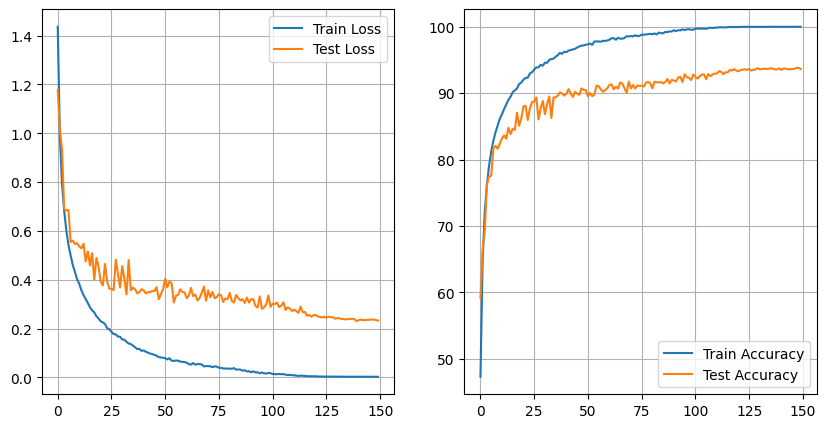

In [20]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
x_axis = range(EPOCHS)
ax0.plot(x_axis, history['loss'], label='Train Loss')
ax0.plot(x_axis, history['test_loss'], label='Test Loss')
ax1.plot(x_axis, history['accuracy'], label='Train Accuracy')
ax1.plot(x_axis, history['test_accuracy'], label='Test Accuracy')
ax0.grid(True)
ax1.grid(True)
ax0.legend()
ax1.legend()
f.savefig("./trainTestCurve.png")

## Visualize the Predictions

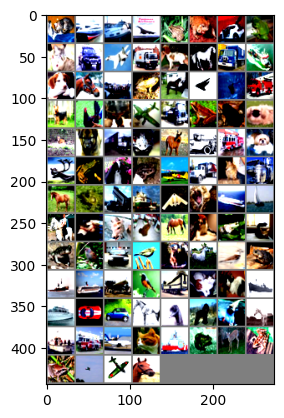

In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Plot Confusion Matrix

In [22]:
def get_predictions(model, iterator, device):
  ## Set model to evaluate mode 

  model.eval()
  
  ## Labels and probability lists 

  labels = []
  probs = []
  
  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

GroundTruth:  cat   ship  ship  plane


In [23]:
labels, probs = get_predictions(net, testloader, device)
pred_labels = torch.argmax(probs, 1)

In [24]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10, 10));
  ax = fig.add_subplot(1, 1, 1);
  cm = confusion_matrix(labels, pred_labels);
  cm = ConfusionMatrixDisplay(cm, display_labels = classes);
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20)

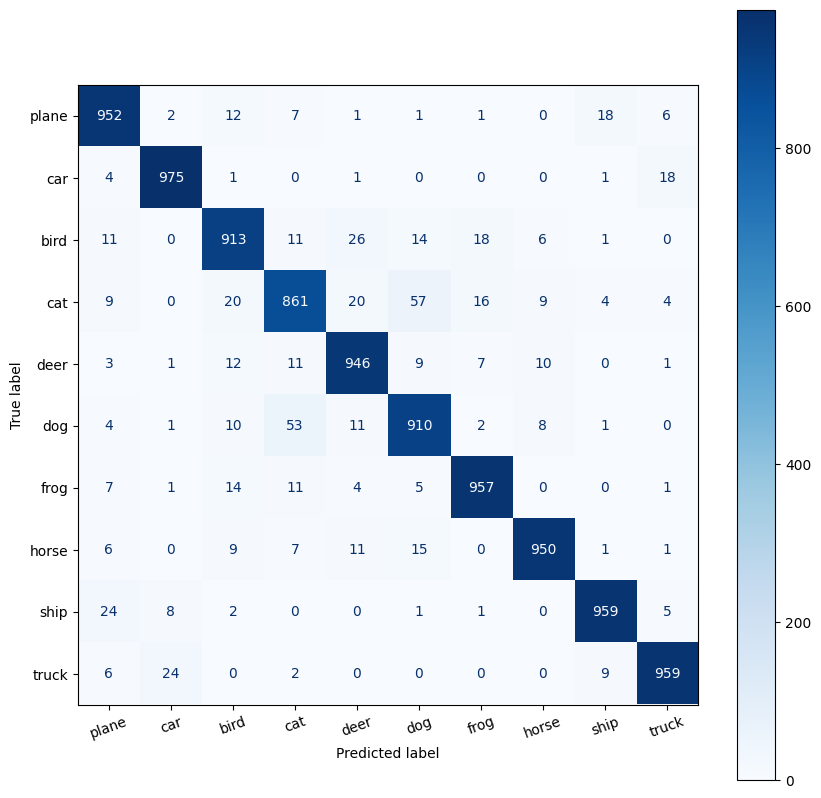

In [25]:
plot_confusion_matrix(labels, pred_labels, classes)